In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import string
import math
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, LSTM, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.layers import Conv1D,GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

import random as python_random
np.random.seed(123) 
python_random.seed(123)
tf.random.set_seed(1234)

import lightgbm as lgb

In [2]:
products_data = pd.read_csv('Dataset/Intermediate/all_products.csv')
products_data.head()

,product_name,brand_name,product_category,description,product_category_wide,mrp,price,%discount
0,"""I DO"" Signature Lace Cheeky Hipster with Gift...",hanky panky,Collections,"With ""I DO"" emblazoned on this Hanky Panky lac...",panties,40.0,40.0,0.0
1,"""I DO"" Signature Lace Cheeky Hipster with Gift...",hanky panky,Panties,"With ""I DO"" emblazoned on this Hanky Panky lac...",panties,40.0,40.0,0.0
2,'After Midnight' Lace Open Gusset G-String,hanky panky,Bridal Lingerie,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
3,'After Midnight' Lace Open Gusset G-String,hanky panky,Sexy Lingerie,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
4,'After Midnight' Lace Open Gusset G-String,hanky panky,Women's Panties,Stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0


In [3]:
products_data['description'] = products_data['description'].str.lower()
products_data['product_name'] = products_data['product_name'].str.lower()
products_data.head()

,product_name,brand_name,product_category,description,product_category_wide,mrp,price,%discount
0,"""i do"" signature lace cheeky hipster with gift...",hanky panky,Collections,"with ""i do"" emblazoned on this hanky panky lac...",panties,40.0,40.0,0.0
1,"""i do"" signature lace cheeky hipster with gift...",hanky panky,Panties,"with ""i do"" emblazoned on this hanky panky lac...",panties,40.0,40.0,0.0
2,'after midnight' lace open gusset g-string,hanky panky,Bridal Lingerie,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
3,'after midnight' lace open gusset g-string,hanky panky,Sexy Lingerie,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0
4,'after midnight' lace open gusset g-string,hanky panky,Women's Panties,stretch signature lace fashions an alluring do...,other,27.0,27.0,0.0


In [4]:
products_data.shape

(5982, 8)

In [5]:
products_data = products_data[['product_name', 'brand_name', 'product_category_wide', 'description', 'mrp']]
products_data.drop_duplicates(inplace = True)
print(products_data.shape)
products_data.head()

(3446, 5)


,product_name,brand_name,product_category_wide,description,mrp
0,"""i do"" signature lace cheeky hipster with gift...",hanky panky,panties,"with ""i do"" emblazoned on this hanky panky lac...",40.0
2,'after midnight' lace open gusset g-string,hanky panky,other,stretch signature lace fashions an alluring do...,27.0
5,'after midnight' open gusset lace thong,hanky panky,panties,leopard-spotted lace adds to the bold open-gus...,24.0
8,'annabelle' lace camisole,hanky panky,camisoles,scalloped trim adorned with a little blue bow ...,64.0
9,'annabelle' lace garter,hanky panky,other,scalloped lace adorned with a little blue bow ...,23.0


In [6]:
# Stopwords removal
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves"]

In [7]:
le = LabelEncoder()

le.fit(np.hstack([products_data.product_category_wide]))
products_data.product_category_wide = le.transform(products_data.product_category_wide)

le.fit(np.hstack([products_data.brand_name]))
products_data.brand_name = le.transform(products_data.brand_name)
del le

products_data.head()

,product_name,brand_name,product_category_wide,description,mrp
0,"""i do"" signature lace cheeky hipster with gift...",6,7,"with ""i do"" emblazoned on this hanky panky lac...",40.0
2,'after midnight' lace open gusset g-string,6,6,stretch signature lace fashions an alluring do...,27.0
5,'after midnight' open gusset lace thong,6,7,leopard-spotted lace adds to the bold open-gus...,24.0
8,'annabelle' lace camisole,6,5,scalloped trim adorned with a little blue bow ...,64.0
9,'annabelle' lace garter,6,6,scalloped lace adorned with a little blue bow ...,23.0


In [8]:
def remove_stopwords(data):
  data['clean_description'] = data['description'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
  return data

data_cleaned = remove_stopwords(products_data)
data_cleaned['clean_description'] = data_cleaned['clean_description'].str.replace('[{}]'.format(string.punctuation), ' ')
data_cleaned.drop('description', inplace = True, axis = 1)
data_cleaned.head()

,product_name,brand_name,product_category_wide,mrp,clean_description
0,"""i do"" signature lace cheeky hipster with gift...",6,7,40.0,i do emblazoned hanky panky lace hipster swa...
2,'after midnight' lace open gusset g-string,6,6,27.0,stretch signature lace fashions alluring doubl...
5,'after midnight' open gusset lace thong,6,7,24.0,leopard spotted lace adds bold open gusset des...
8,'annabelle' lace camisole,6,5,64.0,scalloped trim adorned little blue bow flirts ...
9,'annabelle' lace garter,6,6,23.0,scalloped lace adorned little blue bow defines...


In [9]:
# Tokenizing
raw_text = np.hstack([data_cleaned.clean_description.str.lower(), data_cleaned.product_name.str.lower()])
tok_raw = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tok_raw.fit_on_texts(raw_text)
data_cleaned["seq_description"] = tok_raw.texts_to_sequences(data_cleaned.clean_description.str.lower())
data_cleaned["seq_product_name"] = tok_raw.texts_to_sequences(data_cleaned.product_name.str.lower())
max_seq_description = np.max(data_cleaned.seq_description.apply(lambda x: len(x)))
max_seq_product_name = np.max(data_cleaned.seq_product_name.apply(lambda x: len(x)))
print("Maximum Value of Sequences: ", max_seq_description, max_seq_product_name)

MAX_TEXT = np.max([np.max(data_cleaned.seq_description.apply(lambda x : max(x))),
                   np.max(data_cleaned.seq_product_name.apply(lambda x : max(x)))])  + 3

MAX_BRAND = np.max(data_cleaned.brand_name.max()) + 3
MAX_CAT = np.max(data_cleaned.product_category_wide.max()) + 3

data_cleaned.head()

Maximum Value of Sequences:  91 12


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name
0,"""i do"" signature lace cheeky hipster with gift...",6,7,40.0,i do emblazoned hanky panky lace hipster swa...,"[540, 541, 1760, 83, 90, 1, 98, 1201, 557, 296...","[540, 541, 70, 1, 175, 98, 283, 439, 561]"
2,'after midnight' lace open gusset g-string,6,6,27.0,stretch signature lace fashions alluring doubl...,"[34, 70, 1, 1035, 612, 542, 174, 415, 246, 109...","[2569, 2570, 1, 211, 397, 415, 246]"
5,'after midnight' open gusset lace thong,6,7,24.0,leopard spotted lace adds bold open gusset des...,"[182, 691, 1, 416, 724, 211, 397, 135, 644, 49...","[2569, 2570, 211, 397, 1, 8]"
8,'annabelle' lace camisole,6,5,64.0,scalloped trim adorned little blue bow flirts ...,"[302, 75, 1406, 340, 285, 156, 2620, 521, 77, ...","[2571, 1, 426]"
9,'annabelle' lace garter,6,6,23.0,scalloped lace adorned little blue bow defines...,"[302, 1, 1406, 340, 285, 156, 1990, 1407, 1109...","[2571, 1, 288]"


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

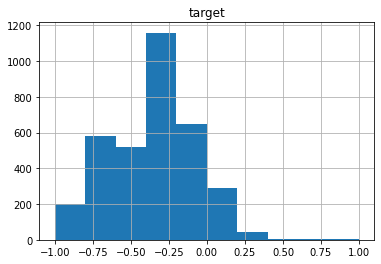

In [10]:
# Min Max Scaler for target
data_cleaned["target"] = np.log(data_cleaned.mrp+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
data_cleaned["target"] = target_scaler.fit_transform(data_cleaned.target.values.reshape(-1,1))
pd.DataFrame(data_cleaned.target).hist()

In [11]:
# Train Test Split
dtrain, dtest = train_test_split(data_cleaned, random_state=123, train_size=0.90)
print(dtrain.shape)
print(dtest.shape)
dtrain.head()

(3101, 8)
(345, 8)


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target
4479,seamless hipster briefs,9,7,13.00,ultrasoft stretchy microfiber shapes comforta...,"[1688, 49, 389, 694, 95, 98, 208, 1933, 303, 3...","[48, 98, 208]",-0.690375
2199,bridget pushup cotton bra,0,4,32.95,flirt everyday perkiness every girl style 97...,"[569, 73, 630, 89, 159, 5, 1070, 1639, 9, 933,...","[643, 66, 7, 2]",-0.294680
843,aerie everyday loves lace thong,0,7,12.50,introducing everyday loves™ made love everyd...,"[356, 73, 357, 32, 39, 73, 116, 258, 234, 140,...","[14, 73, 116, 1, 8]",-0.706620
324,aerie bikini,0,6,9.50,peek cheek lot wow soft comfy cotton love fi...,"[27, 26, 230, 207, 18, 20, 7, 39, 23, 65, 87, ...","[14, 38]",-0.818881
3247,id logo mesh-panel hipster qf1780,2,7,22.00,kick style notch logo enhanced cooling hipster...,"[1690, 5, 2943, 35, 701, 1889, 98, 54, 59]","[406, 35, 36, 364, 98, 3654]",-0.468620


In [12]:
# Sequence Padding
def get_keras_data(dataset):
    X = {
        'item_name':  pad_sequences(dataset.seq_product_name, maxlen=10),
        'item_desc': pad_sequences(dataset.seq_description, maxlen=75),
        'brand_name': np.array(dataset.brand_name),
        'product_category': np.array(dataset.product_category_wide)
    }
    return X

X_train = get_keras_data(dtrain)
X_test = get_keras_data(dtest)
X_train

{'item_name': array([[   0,    0,    0, ...,   48,   98,  208],
        [   0,    0,    0, ...,   66,    7,    2],
        [   0,    0,    0, ...,  116,    1,    8],
        ...,
        [   0,  165,  133, ...,  288,  452, 3534],
        [   0,    0,    0, ...,  833,   19, 3582],
        [   0,    0,    0, ...,  118,  132,    2]]),
 'item_desc': array([[   0,    0,    0, ...,   62,  304,   23],
        [   0,    0,    0, ...,    3,    3,   11],
        [   0,    0,    0, ...,    3,    3,   11],
        ...,
        [   0,    0,    0, ...,  133,   54,   59],
        [   0,    0,    0, ...,  238,  243,  135],
        [   0,    0,    0, ...,  264,  837, 1243]]),
 'brand_name': array([9, 0, 0, ..., 2, 6, 2]),
 'product_category': array([ 7,  4,  7, ..., 12,  3,  4])}

## GRU Based Model

In [13]:
# Model Training
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_gru_model(data):
    # Params
    dr_r = 0.1
    
    # Inputs
    item_name = Input(shape=[data["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[data["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")
    
    # Embeddings Layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)
    
    # RNN Layer
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_item_name)
    
    # Main Layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_brand_name)
        , Flatten() (emb_product_category)
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output Layer
    output = Dense(1, activation="linear") (main_l)
    
    # Init Model
    model = Model([item_name, item_desc, brand_name, product_category], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
gru_model = get_gru_model(X_train)

# Calculation of Loss History
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()
gru_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                              

In [14]:
# Model Fitting

BATCH_SIZE = 2500
epochs = 50
gru_model = get_gru_model(X_train)
gru_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[history])

Epoch 1/50
2/2 [==============================] - 8s 2s/step - loss: 0.1951 - mae: 0.3718 - rmsle_cust: 0.0211 - val_loss: 0.1163 - val_mae: 0.2708 - val_rmsle_cust: 0.0077
Epoch 2/50
2/2 [==============================] - 1s 198ms/step - loss: 0.1211 - mae: 0.2801 - rmsle_cust: 0.0101 - val_loss: 0.0669 - val_mae: 0.2008 - val_rmsle_cust: 0.0077
Epoch 3/50
2/2 [==============================] - 1s 216ms/step - loss: 0.0706 - mae: 0.2079 - rmsle_cust: 0.0101 - val_loss: 0.0471 - val_mae: 0.1800 - val_rmsle_cust: 0.0077
Epoch 4/50
2/2 [==============================] - 1s 215ms/step - loss: 0.0513 - mae: 0.1858 - rmsle_cust: 0.0101 - val_loss: 0.0563 - val_mae: 0.2031 - val_rmsle_cust: 0.0077
Epoch 5/50
2/2 [==============================] - 1s 217ms/step - loss: 0.0591 - mae: 0.2033 - rmsle_cust: 0.0101 - val_loss: 0.0557 - val_mae: 0.1993 - val_rmsle_cust: 0.0077
Epoch 6/50
2/2 [==============================] - 1s 217ms/step - loss: 0.0555 - mae: 0.1942 - rmsle_cust: 0.0101 - val_los

2/2 [==============================] - 1s 186ms/step - loss: 0.0037 - mae: 0.0423 - rmsle_cust: 0.0035 - val_loss: 0.0083 - val_mae: 0.0645 - val_rmsle_cust: 0.0053
Epoch 48/50
2/2 [==============================] - 1s 203ms/step - loss: 0.0036 - mae: 0.0426 - rmsle_cust: 0.0036 - val_loss: 0.0083 - val_mae: 0.0642 - val_rmsle_cust: 0.0053
Epoch 49/50
2/2 [==============================] - 0s 184ms/step - loss: 0.0034 - mae: 0.0406 - rmsle_cust: 0.0036 - val_loss: 0.0083 - val_mae: 0.0639 - val_rmsle_cust: 0.0055
Epoch 50/50
2/2 [==============================] - 0s 193ms/step - loss: 0.0034 - mae: 0.0413 - rmsle_cust: 0.0035 - val_loss: 0.0083 - val_mae: 0.0639 - val_rmsle_cust: 0.0055


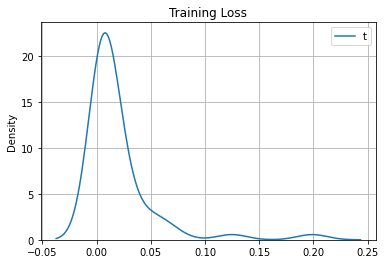

In [15]:
loss_range=np.log(history.losses)
sns.distplot(history.losses, hist=False)
plt.title('Training Loss')
plt.grid()
plt.legend('top')
plt.show()

In [16]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

val_preds = gru_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for GRU Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for GRU Based Model on Test Data: "+str(v_rmse))

11/11 [==============================] - 1s 11ms/step
 RMSLE error for GRU Based Model on Test Data: 0.22893180024344015
 RMSE error for GRU Based Model on Test Data: 8.495720831382716


In [17]:
# Predict the price.
preds = gru_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1
dtest["predicted_price"] = preds
dtest.head()

1/1 [==============================] - 0s 63ms/step


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target,predicted_price
3619,logo to go low rise thong 631581,6,7,22.00,soft sheer lace wraps around waist lightweigh...,"[18, 72, 1, 1261, 521, 161, 264, 20, 8, 83, 90]","[35, 87, 65, 21, 16, 8, 1980]",-0.468620,30.259712
3444,lace plunge bra,12,4,35.00,elegant black plunge bra prettified gorgeous l...,"[488, 133, 80, 2, 2973, 238, 1, 711, 109, 324,...","[1, 80, 2]",-0.268490,28.239491
2517,classic mesh triangle bralette,6,3,54.00,classic silhouettes airy stretch mesh,"[100, 682, 616, 34, 36]","[100, 36, 68, 19]",-0.079174,52.706375
3076,happy unlined bandeau bra,0,4,26.95,hello happy bras happiness feeling like real...,"[240, 52, 92, 148, 269, 150, 12, 235, 360, 52,...","[52, 169, 312, 2]",-0.381549,27.374535
5635,b.provocative contrast-lace bra 951222,1,4,40.00,flattering sheer nude panels decorated intrica...,"[215, 72, 393, 781, 999, 571, 1250, 325, 3311,...","[67, 686, 216, 1, 2, 3892]",-0.210396,37.524208


In [21]:
kf = KFold(n_splits=10, random_state=1, shuffle=True) 
kgru_output = []
for train_index, test_index in kf.split(data_cleaned):
#     print("Train:", train_index, "Validation:",test_index)
    KX_train, KX_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]
    KXX_train = get_keras_data(KX_train)
    KXX_test = get_keras_data(KX_test)
    gru_model = get_gru_model(KXX_train)
    gru_model.fit(KXX_train, KX_train.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(KXX_test, KX_test.target)
          , verbose=1, callbacks=[history])
    val_preds = gru_model.predict(KXX_test)
    val_preds = target_scaler.inverse_transform(val_preds)
    val_preds = np.exp(val_preds)+1
    y_true = np.array(KX_test.mrp.values)
    y_pred = val_preds[:,0]
    v_rmsle = rmsle(y_true, y_pred)
    v_rmse = mean_squared_error(y_true, y_pred , squared=False)
    output.append([v_rmse, v_rmsle])

Train: [   0    1    2 ... 3443 3444 3445] Validation: [   3    6    7   12   13   28   40   45   75   89   93   94   98   99
  102  110  126  136  161  165  171  187  188  201  203  205  224  230
  254  255  262  268  280  291  297  301  306  318  321  329  330  331
  349  351  366  368  382  393  397  403  420  442  453  464  473  481
  487  494  495  517  534  540  541  546  557  560  563  581  582  588
  592  598  600  605  610  613  632  644  650  671  678  702  705  709
  719  725  730  748  772  774  777  784  790  792  796  799  802  870
  876  899  902  913  925  927  929  943  946  955  957  968  979  984
  988  993  994 1002 1004 1020 1045 1060 1065 1074 1098 1100 1103 1128
 1135 1138 1141 1142 1153 1163 1164 1171 1173 1177 1179 1196 1201 1232
 1247 1265 1268 1270 1271 1273 1291 1294 1301 1305 1335 1396 1413 1421
 1436 1450 1452 1459 1503 1509 1517 1520 1526 1537 1545 1548 1554 1584
 1611 1614 1621 1647 1649 1661 1672 1674 1685 1687 1697 1723 1732 1744
 1754 1759 1765 1805 1

2/2 [==============================] - 1s 211ms/step - loss: 0.0041 - mae: 0.0451 - rmsle_cust: 0.0040 - val_loss: 0.0105 - val_mae: 0.0668 - val_rmsle_cust: 0.0078
Epoch 38/50
2/2 [==============================] - 1s 227ms/step - loss: 0.0039 - mae: 0.0445 - rmsle_cust: 0.0040 - val_loss: 0.0104 - val_mae: 0.0665 - val_rmsle_cust: 0.0078
Epoch 39/50
2/2 [==============================] - 1s 188ms/step - loss: 0.0039 - mae: 0.0442 - rmsle_cust: 0.0039 - val_loss: 0.0104 - val_mae: 0.0663 - val_rmsle_cust: 0.0077
Epoch 40/50
2/2 [==============================] - 1s 220ms/step - loss: 0.0038 - mae: 0.0436 - rmsle_cust: 0.0038 - val_loss: 0.0103 - val_mae: 0.0660 - val_rmsle_cust: 0.0076
Epoch 41/50
2/2 [==============================] - 1s 196ms/step - loss: 0.0039 - mae: 0.0435 - rmsle_cust: 0.0039 - val_loss: 0.0103 - val_mae: 0.0660 - val_rmsle_cust: 0.0076
Epoch 42/50
2/2 [==============================] - 1s 197ms/step - loss: 0.0037 - mae: 0.0425 - rmsle_cust: 0.0037 - val_loss: 

Epoch 23/50
2/2 [==============================] - 1s 415ms/step - loss: 0.0079 - mae: 0.0635 - rmsle_cust: 0.0056 - val_loss: 0.0121 - val_mae: 0.0783 - val_rmsle_cust: 0.0076
Epoch 24/50
2/2 [==============================] - 1s 285ms/step - loss: 0.0073 - mae: 0.0615 - rmsle_cust: 0.0054 - val_loss: 0.0118 - val_mae: 0.0766 - val_rmsle_cust: 0.0076
Epoch 25/50
2/2 [==============================] - 1s 292ms/step - loss: 0.0071 - mae: 0.0601 - rmsle_cust: 0.0055 - val_loss: 0.0116 - val_mae: 0.0756 - val_rmsle_cust: 0.0078
Epoch 26/50
2/2 [==============================] - 1s 233ms/step - loss: 0.0067 - mae: 0.0580 - rmsle_cust: 0.0055 - val_loss: 0.0113 - val_mae: 0.0739 - val_rmsle_cust: 0.0080
Epoch 27/50
2/2 [==============================] - 1s 257ms/step - loss: 0.0065 - mae: 0.0573 - rmsle_cust: 0.0056 - val_loss: 0.0109 - val_mae: 0.0718 - val_rmsle_cust: 0.0081
Epoch 28/50
2/2 [==============================] - 1s 241ms/step - loss: 0.0061 - mae: 0.0552 - rmsle_cust: 0.0058 

Epoch 9/50
2/2 [==============================] - 1s 196ms/step - loss: 0.0305 - mae: 0.1339 - rmsle_cust: 0.0096 - val_loss: 0.0327 - val_mae: 0.1408 - val_rmsle_cust: 0.0118
Epoch 10/50
2/2 [==============================] - 1s 195ms/step - loss: 0.0300 - mae: 0.1344 - rmsle_cust: 0.0098 - val_loss: 0.0301 - val_mae: 0.1351 - val_rmsle_cust: 0.0121
Epoch 11/50
2/2 [==============================] - 1s 183ms/step - loss: 0.0272 - mae: 0.1297 - rmsle_cust: 0.0099 - val_loss: 0.0249 - val_mae: 0.1209 - val_rmsle_cust: 0.0123
Epoch 12/50
2/2 [==============================] - 1s 200ms/step - loss: 0.0221 - mae: 0.1144 - rmsle_cust: 0.0104 - val_loss: 0.0210 - val_mae: 0.1068 - val_rmsle_cust: 0.0122
Epoch 13/50
2/2 [==============================] - 1s 200ms/step - loss: 0.0189 - mae: 0.1024 - rmsle_cust: 0.0102 - val_loss: 0.0206 - val_mae: 0.1036 - val_rmsle_cust: 0.0118
Epoch 14/50
2/2 [==============================] - 1s 214ms/step - loss: 0.0187 - mae: 0.0984 - rmsle_cust: 0.0099 -

Epoch 1/50
2/2 [==============================] - 5s 904ms/step - loss: 0.1808 - mae: 0.3478 - rmsle_cust: 0.0115 - val_loss: 0.1169 - val_mae: 0.2673 - val_rmsle_cust: 0.0105
Epoch 2/50
2/2 [==============================] - 1s 198ms/step - loss: 0.1200 - mae: 0.2720 - rmsle_cust: 0.0098 - val_loss: 0.0749 - val_mae: 0.2104 - val_rmsle_cust: 0.0105
Epoch 3/50
2/2 [==============================] - 1s 184ms/step - loss: 0.0772 - mae: 0.2162 - rmsle_cust: 0.0098 - val_loss: 0.0587 - val_mae: 0.1975 - val_rmsle_cust: 0.0105
Epoch 4/50
2/2 [==============================] - 1s 191ms/step - loss: 0.0606 - mae: 0.2036 - rmsle_cust: 0.0098 - val_loss: 0.0619 - val_mae: 0.2083 - val_rmsle_cust: 0.0105
Epoch 5/50
2/2 [==============================] - 1s 181ms/step - loss: 0.0605 - mae: 0.2077 - rmsle_cust: 0.0098 - val_loss: 0.0552 - val_mae: 0.1933 - val_rmsle_cust: 0.0105
Epoch 6/50
2/2 [==============================] - 1s 191ms/step - loss: 0.0518 - mae: 0.1899 - rmsle_cust: 0.0098 - val_

2/2 [==============================] - 1s 231ms/step - loss: 0.0032 - mae: 0.0402 - rmsle_cust: 0.0035 - val_loss: 0.0097 - val_mae: 0.0654 - val_rmsle_cust: 0.0063
Epoch 48/50
2/2 [==============================] - 1s 195ms/step - loss: 0.0032 - mae: 0.0401 - rmsle_cust: 0.0034 - val_loss: 0.0096 - val_mae: 0.0648 - val_rmsle_cust: 0.0063
Epoch 49/50
2/2 [==============================] - 1s 217ms/step - loss: 0.0031 - mae: 0.0396 - rmsle_cust: 0.0034 - val_loss: 0.0095 - val_mae: 0.0644 - val_rmsle_cust: 0.0063
Epoch 50/50
11/11 [==============================] - 1s 9ms/step
Train: [   0    2    3 ... 3443 3444 3445] Validation: [   1    8   11   16   24   30   37   38   48   62   76   90  101  115
  128  140  173  189  190  198  200  206  207  212  223  229  258  261
  293  294  325  332  345  350  353  363  372  375  385  389  398  400
  406  421  441  443  447  448  484  493  520  523  583  585  614  628
  631  639  640  642  669  689  697  698  718  745  747  750  763  769
  778 

Epoch 33/50
2/2 [==============================] - 1s 264ms/step - loss: 0.0052 - mae: 0.0501 - rmsle_cust: 0.0047 - val_loss: 0.0106 - val_mae: 0.0726 - val_rmsle_cust: 0.0067
Epoch 34/50
2/2 [==============================] - 1s 244ms/step - loss: 0.0052 - mae: 0.0504 - rmsle_cust: 0.0047 - val_loss: 0.0105 - val_mae: 0.0718 - val_rmsle_cust: 0.0066
Epoch 35/50
2/2 [==============================] - 1s 260ms/step - loss: 0.0050 - mae: 0.0492 - rmsle_cust: 0.0045 - val_loss: 0.0103 - val_mae: 0.0708 - val_rmsle_cust: 0.0066
Epoch 36/50
2/2 [==============================] - 1s 253ms/step - loss: 0.0049 - mae: 0.0484 - rmsle_cust: 0.0041 - val_loss: 0.0102 - val_mae: 0.0700 - val_rmsle_cust: 0.0066
Epoch 37/50
2/2 [==============================] - 1s 250ms/step - loss: 0.0048 - mae: 0.0480 - rmsle_cust: 0.0041 - val_loss: 0.0101 - val_mae: 0.0696 - val_rmsle_cust: 0.0066
Epoch 38/50
2/2 [==============================] - 1s 249ms/step - loss: 0.0047 - mae: 0.0478 - rmsle_cust: 0.0043 

Epoch 19/50
2/2 [==============================] - 1s 238ms/step - loss: 0.0111 - mae: 0.0794 - rmsle_cust: 0.0081 - val_loss: 0.0122 - val_mae: 0.0831 - val_rmsle_cust: 0.0045
Epoch 20/50
2/2 [==============================] - 1s 229ms/step - loss: 0.0093 - mae: 0.0702 - rmsle_cust: 0.0067 - val_loss: 0.0108 - val_mae: 0.0750 - val_rmsle_cust: 0.0043
Epoch 21/50
2/2 [==============================] - 1s 216ms/step - loss: 0.0085 - mae: 0.0656 - rmsle_cust: 0.0062 - val_loss: 0.0105 - val_mae: 0.0739 - val_rmsle_cust: 0.0042
Epoch 22/50
2/2 [==============================] - 1s 221ms/step - loss: 0.0085 - mae: 0.0670 - rmsle_cust: 0.0060 - val_loss: 0.0104 - val_mae: 0.0743 - val_rmsle_cust: 0.0042
Epoch 23/50
2/2 [==============================] - 1s 208ms/step - loss: 0.0087 - mae: 0.0683 - rmsle_cust: 0.0059 - val_loss: 0.0101 - val_mae: 0.0722 - val_rmsle_cust: 0.0042
Epoch 24/50
2/2 [==============================] - 1s 228ms/step - loss: 0.0079 - mae: 0.0646 - rmsle_cust: 0.0058 

Epoch 5/50
2/2 [==============================] - 1s 304ms/step - loss: 0.0639 - mae: 0.2116 - rmsle_cust: 0.0099 - val_loss: 0.0515 - val_mae: 0.1860 - val_rmsle_cust: 0.0095
Epoch 6/50
2/2 [==============================] - 1s 341ms/step - loss: 0.0509 - mae: 0.1864 - rmsle_cust: 0.0099 - val_loss: 0.0386 - val_mae: 0.1591 - val_rmsle_cust: 0.0095
Epoch 7/50
2/2 [==============================] - 2s 457ms/step - loss: 0.0361 - mae: 0.1524 - rmsle_cust: 0.0099 - val_loss: 0.0342 - val_mae: 0.1467 - val_rmsle_cust: 0.0096
Epoch 8/50
2/2 [==============================] - 1s 340ms/step - loss: 0.0302 - mae: 0.1356 - rmsle_cust: 0.0098 - val_loss: 0.0336 - val_mae: 0.1478 - val_rmsle_cust: 0.0099
Epoch 9/50
2/2 [==============================] - 1s 454ms/step - loss: 0.0283 - mae: 0.1315 - rmsle_cust: 0.0097 - val_loss: 0.0294 - val_mae: 0.1412 - val_rmsle_cust: 0.0102
Epoch 10/50
2/2 [==============================] - 1s 320ms/step - loss: 0.0243 - mae: 0.1231 - rmsle_cust: 0.0099 - val

Epoch 1/50
2/2 [==============================] - 5s 1s/step - loss: 0.1898 - mae: 0.3618 - rmsle_cust: 0.0170 - val_loss: 0.1233 - val_mae: 0.2775 - val_rmsle_cust: 0.0099
Epoch 2/50
2/2 [==============================] - 1s 300ms/step - loss: 0.1276 - mae: 0.2824 - rmsle_cust: 0.0099 - val_loss: 0.0797 - val_mae: 0.2204 - val_rmsle_cust: 0.0099
Epoch 3/50
2/2 [==============================] - 1s 458ms/step - loss: 0.0833 - mae: 0.2230 - rmsle_cust: 0.0099 - val_loss: 0.0594 - val_mae: 0.2004 - val_rmsle_cust: 0.0099
Epoch 4/50
2/2 [==============================] - 1s 279ms/step - loss: 0.0628 - mae: 0.2055 - rmsle_cust: 0.0099 - val_loss: 0.0639 - val_mae: 0.2165 - val_rmsle_cust: 0.0099
Epoch 5/50
2/2 [==============================] - 1s 236ms/step - loss: 0.0646 - mae: 0.2166 - rmsle_cust: 0.0099 - val_loss: 0.0652 - val_mae: 0.2172 - val_rmsle_cust: 0.0099
Epoch 6/50
2/2 [==============================] - 1s 427ms/step - loss: 0.0632 - mae: 0.2120 - rmsle_cust: 0.0099 - val_los

2/2 [==============================] - 1s 484ms/step - loss: 0.0033 - mae: 0.0406 - rmsle_cust: 0.0033 - val_loss: 0.0088 - val_mae: 0.0650 - val_rmsle_cust: 0.0066
Epoch 48/50
2/2 [==============================] - 1s 494ms/step - loss: 0.0033 - mae: 0.0412 - rmsle_cust: 0.0035 - val_loss: 0.0087 - val_mae: 0.0646 - val_rmsle_cust: 0.0066
Epoch 49/50
2/2 [==============================] - 1s 375ms/step - loss: 0.0033 - mae: 0.0407 - rmsle_cust: 0.0035 - val_loss: 0.0086 - val_mae: 0.0641 - val_rmsle_cust: 0.0066
Epoch 50/50
11/11 [==============================] - 1s 22ms/step
Train: [   0    1    2 ... 3443 3444 3445] Validation: [  14   18   36   42   52   70   71   92   95  105  112  113  114  116
  118  122  153  162  168  174  179  184  197  213  214  225  232  240
  245  246  247  249  263  271  272  296  312  317  333  334  337  342
  343  344  356  362  373  377  378  379  402  410  411  412  417  454
  467  506  519  522  539  552  565  580  601  611  621  651  652  657
  658

Epoch 33/50
2/2 [==============================] - 2s 404ms/step - loss: 0.0050 - mae: 0.0507 - rmsle_cust: 0.0046 - val_loss: 0.0111 - val_mae: 0.0702 - val_rmsle_cust: 0.0050
Epoch 34/50
2/2 [==============================] - 2s 453ms/step - loss: 0.0047 - mae: 0.0489 - rmsle_cust: 0.0043 - val_loss: 0.0108 - val_mae: 0.0688 - val_rmsle_cust: 0.0050
Epoch 35/50
2/2 [==============================] - 2s 373ms/step - loss: 0.0046 - mae: 0.0483 - rmsle_cust: 0.0044 - val_loss: 0.0107 - val_mae: 0.0681 - val_rmsle_cust: 0.0049
Epoch 36/50
2/2 [==============================] - 2s 437ms/step - loss: 0.0044 - mae: 0.0475 - rmsle_cust: 0.0044 - val_loss: 0.0107 - val_mae: 0.0679 - val_rmsle_cust: 0.0048
Epoch 37/50
2/2 [==============================] - 2s 612ms/step - loss: 0.0043 - mae: 0.0467 - rmsle_cust: 0.0040 - val_loss: 0.0107 - val_mae: 0.0685 - val_rmsle_cust: 0.0048
Epoch 38/50
2/2 [==============================] - 2s 418ms/step - loss: 0.0042 - mae: 0.0462 - rmsle_cust: 0.0040 

Epoch 19/50
2/2 [==============================] - 1s 271ms/step - loss: 0.0087 - mae: 0.0690 - rmsle_cust: 0.0065 - val_loss: 0.0155 - val_mae: 0.0908 - val_rmsle_cust: 0.0086
Epoch 20/50
2/2 [==============================] - 1s 249ms/step - loss: 0.0079 - mae: 0.0654 - rmsle_cust: 0.0060 - val_loss: 0.0156 - val_mae: 0.0911 - val_rmsle_cust: 0.0088
Epoch 21/50
2/2 [==============================] - 1s 257ms/step - loss: 0.0081 - mae: 0.0661 - rmsle_cust: 0.0058 - val_loss: 0.0159 - val_mae: 0.0925 - val_rmsle_cust: 0.0088
Epoch 22/50
2/2 [==============================] - 1s 275ms/step - loss: 0.0080 - mae: 0.0660 - rmsle_cust: 0.0057 - val_loss: 0.0154 - val_mae: 0.0907 - val_rmsle_cust: 0.0087
Epoch 23/50
2/2 [==============================] - 1s 276ms/step - loss: 0.0074 - mae: 0.0629 - rmsle_cust: 0.0052 - val_loss: 0.0147 - val_mae: 0.0881 - val_rmsle_cust: 0.0084
Epoch 24/50
2/2 [==============================] - 1s 247ms/step - loss: 0.0068 - mae: 0.0594 - rmsle_cust: 0.0053 

In [22]:
print(" RMSLE error for GRU Based Model on Test Data for K-Fold Validation: "+str(sum([i[1] for i in output])/len(output)))
print(" RMSE error for GRU Based Model on Test Data for K-Fold Validation: "+str(sum([i[0] for i in output])/len(output)))

 RMSLE error for GRU Based Model on Test Data for K-Fold Validation: 0.24197557239766782
 RMSE error for GRU Based Model on Test Data for K-Fold Validation: 11.3019072419932


## LSTM Based Model

In [23]:
def get_lstm_model(data):
    # Params
    dr_r = 0.1
    
    # Inputs
    item_name = Input(shape=[data["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[data["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")
    
    # Embeddings Layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)
    
    # RNN Layer
    rnn_layer1 = LSTM(16) (emb_item_desc)
    rnn_layer2 = LSTM(8) (emb_item_name)
    
    # Main Layer
    main_l = concatenate([
        rnn_layer1,
        rnn_layer2,
        Flatten() (emb_brand_name)
        , Flatten() (emb_product_category)
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    # Output Layer
    output = Dense(1, activation="linear") (main_l)
    
    # Init Model
    model = Model([item_name, item_desc, brand_name, product_category], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
lstm_model = get_lstm_model(X_train)
history = LossHistory()
lstm_model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 product_category (InputLayer)  [(None, 1)]          0           []                               
                                                                                           

In [24]:
lstm_model = get_lstm_model(X_train)
lstm_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_test, dtest.target)
          , verbose=1, callbacks=[history])

Epoch 1/50
2/2 [==============================] - 6s 1s/step - loss: 0.1842 - mae: 0.3558 - rmsle_cust: 0.0155 - val_loss: 0.1133 - val_mae: 0.2637 - val_rmsle_cust: 0.0077
Epoch 2/50
2/2 [==============================] - 1s 512ms/step - loss: 0.1216 - mae: 0.2751 - rmsle_cust: 0.0101 - val_loss: 0.0711 - val_mae: 0.2052 - val_rmsle_cust: 0.0077
Epoch 3/50
2/2 [==============================] - 2s 613ms/step - loss: 0.0775 - mae: 0.2168 - rmsle_cust: 0.0101 - val_loss: 0.0621 - val_mae: 0.2076 - val_rmsle_cust: 0.0077
Epoch 4/50
2/2 [==============================] - 1s 403ms/step - loss: 0.0675 - mae: 0.2145 - rmsle_cust: 0.0101 - val_loss: 0.0674 - val_mae: 0.2225 - val_rmsle_cust: 0.0077
Epoch 5/50
2/2 [==============================] - 1s 383ms/step - loss: 0.0685 - mae: 0.2208 - rmsle_cust: 0.0101 - val_loss: 0.0538 - val_mae: 0.1968 - val_rmsle_cust: 0.0077
Epoch 6/50
2/2 [==============================] - 1s 465ms/step - loss: 0.0543 - mae: 0.1938 - rmsle_cust: 0.0101 - val_los

2/2 [==============================] - 1s 462ms/step - loss: 0.0030 - mae: 0.0402 - rmsle_cust: 0.0033 - val_loss: 0.0069 - val_mae: 0.0589 - val_rmsle_cust: 0.0045
Epoch 48/50
2/2 [==============================] - 1s 392ms/step - loss: 0.0030 - mae: 0.0404 - rmsle_cust: 0.0032 - val_loss: 0.0069 - val_mae: 0.0586 - val_rmsle_cust: 0.0045
Epoch 49/50
2/2 [==============================] - 1s 389ms/step - loss: 0.0029 - mae: 0.0394 - rmsle_cust: 0.0030 - val_loss: 0.0069 - val_mae: 0.0584 - val_rmsle_cust: 0.0045
Epoch 50/50
2/2 [==============================] - 1s 409ms/step - loss: 0.0028 - mae: 0.0389 - rmsle_cust: 0.0034 - val_loss: 0.0068 - val_mae: 0.0581 - val_rmsle_cust: 0.0045


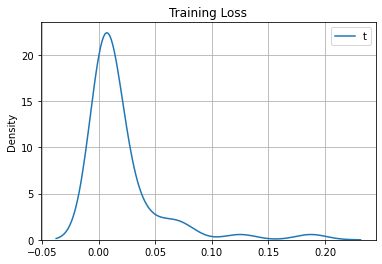

In [26]:
loss_range=np.log(history.losses)
sns.distplot(history.losses, hist=False)
plt.title('Training Loss')
plt.grid()
plt.legend('top')
plt.show()

In [27]:
val_preds = lstm_model.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print(" RMSLE error for LSTM Based Model on Test Data: "+str(v_rmsle))
print(" RMSE error for LSTM Based Model on Test Data: "+str(v_rmse))

11/11 [==============================] - 1s 10ms/step
 RMSLE error for LSTM Based Model on Test Data: 0.2106766146729653
 RMSE error for LSTM Based Model on Test Data: 7.451365961524918


In [28]:
# Predict the price.
preds = lstm_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1
dtest["predicted_price"] = preds
dtest.head()

1/1 [==============================] - 0s 76ms/step


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target,predicted_price
3619,logo to go low rise thong 631581,6,7,22.00,soft sheer lace wraps around waist lightweigh...,"[18, 72, 1, 1261, 521, 161, 264, 20, 8, 83, 90]","[35, 87, 65, 21, 16, 8, 1980]",-0.468620,24.776022
3444,lace plunge bra,12,4,35.00,elegant black plunge bra prettified gorgeous l...,"[488, 133, 80, 2, 2973, 238, 1, 711, 109, 324,...","[1, 80, 2]",-0.268490,27.632160
2517,classic mesh triangle bralette,6,3,54.00,classic silhouettes airy stretch mesh,"[100, 682, 616, 34, 36]","[100, 36, 68, 19]",-0.079174,50.406063
3076,happy unlined bandeau bra,0,4,26.95,hello happy bras happiness feeling like real...,"[240, 52, 92, 148, 269, 150, 12, 235, 360, 52,...","[52, 169, 312, 2]",-0.381549,26.959198
5635,b.provocative contrast-lace bra 951222,1,4,40.00,flattering sheer nude panels decorated intrica...,"[215, 72, 393, 781, 999, 571, 1250, 325, 3311,...","[67, 686, 216, 1, 2, 3892]",-0.210396,38.890709


In [33]:
kf = KFold(n_splits=10, random_state=1, shuffle=True) 
klstm_output = []
for train_index, test_index in kf.split(data_cleaned):
#     print("Train:", train_index, "Validation:",test_index)
    KX_train, KX_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]
    KXX_train = get_keras_data(KX_train)
    KXX_test = get_keras_data(KX_test)
    lstm_model = get_lstm_model(KXX_train)
    lstm_model.fit(KXX_train, KX_train.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(KXX_test, KX_test.target)
          , verbose=1, callbacks=[history])
    val_preds = lstm_model.predict(KXX_test)
    val_preds = target_scaler.inverse_transform(val_preds)
    val_preds = np.exp(val_preds)+1

    # mean_absolute_error, mean_squared_log_error.
    y_true = np.array(KX_test.mrp.values)
    y_pred = val_preds[:,0]
    v_rmsle = rmsle(y_true, y_pred)
    v_rmse = mean_squared_error(y_true, y_pred , squared=False)
    klstm_output.append([v_rmse, v_rmsle])

Epoch 1/50
2/2 [==============================] - 5s 1s/step - loss: 0.1994 - mae: 0.3724 - rmsle_cust: 0.0201 - val_loss: 0.1331 - val_mae: 0.2952 - val_rmsle_cust: 0.0100
Epoch 2/50
2/2 [==============================] - 1s 414ms/step - loss: 0.1344 - mae: 0.2932 - rmsle_cust: 0.0099 - val_loss: 0.0851 - val_mae: 0.2255 - val_rmsle_cust: 0.0100
Epoch 3/50
2/2 [==============================] - 1s 454ms/step - loss: 0.0880 - mae: 0.2295 - rmsle_cust: 0.0099 - val_loss: 0.0591 - val_mae: 0.1889 - val_rmsle_cust: 0.0100
Epoch 4/50
2/2 [==============================] - 1s 550ms/step - loss: 0.0629 - mae: 0.2027 - rmsle_cust: 0.0099 - val_loss: 0.0580 - val_mae: 0.1976 - val_rmsle_cust: 0.0100
Epoch 5/50
2/2 [==============================] - 1s 348ms/step - loss: 0.0608 - mae: 0.2077 - rmsle_cust: 0.0099 - val_loss: 0.0609 - val_mae: 0.2053 - val_rmsle_cust: 0.0100
Epoch 6/50
2/2 [==============================] - 1s 353ms/step - loss: 0.0607 - mae: 0.2065 - rmsle_cust: 0.0099 - val_los

2/2 [==============================] - 1s 362ms/step - loss: 0.0029 - mae: 0.0394 - rmsle_cust: 0.0032 - val_loss: 0.0081 - val_mae: 0.0597 - val_rmsle_cust: 0.0070
Epoch 48/50
2/2 [==============================] - 1s 370ms/step - loss: 0.0029 - mae: 0.0390 - rmsle_cust: 0.0032 - val_loss: 0.0080 - val_mae: 0.0594 - val_rmsle_cust: 0.0070
Epoch 49/50
2/2 [==============================] - 1s 371ms/step - loss: 0.0028 - mae: 0.0384 - rmsle_cust: 0.0031 - val_loss: 0.0080 - val_mae: 0.0592 - val_rmsle_cust: 0.0070
Epoch 50/50
11/11 [==============================] - 1s 9ms/step
Epoch 1/50
2/2 [==============================] - 5s 1s/step - loss: 0.1791 - mae: 0.3499 - rmsle_cust: 0.0140 - val_loss: 0.1193 - val_mae: 0.2731 - val_rmsle_cust: 0.0095
Epoch 2/50
2/2 [==============================] - 1s 329ms/step - loss: 0.1184 - mae: 0.2730 - rmsle_cust: 0.0099 - val_loss: 0.0783 - val_mae: 0.2161 - val_rmsle_cust: 0.0095
Epoch 3/50
2/2 [==============================] - 1s 339ms/step - l

2/2 [==============================] - 1s 411ms/step - loss: 0.0030 - mae: 0.0400 - rmsle_cust: 0.0036 - val_loss: 0.0086 - val_mae: 0.0627 - val_rmsle_cust: 0.0066
Epoch 44/50
2/2 [==============================] - 1s 338ms/step - loss: 0.0027 - mae: 0.0375 - rmsle_cust: 0.0035 - val_loss: 0.0086 - val_mae: 0.0624 - val_rmsle_cust: 0.0066
Epoch 45/50
2/2 [==============================] - 1s 362ms/step - loss: 0.0029 - mae: 0.0385 - rmsle_cust: 0.0033 - val_loss: 0.0086 - val_mae: 0.0624 - val_rmsle_cust: 0.0065
Epoch 46/50
2/2 [==============================] - 1s 361ms/step - loss: 0.0027 - mae: 0.0377 - rmsle_cust: 0.0033 - val_loss: 0.0086 - val_mae: 0.0625 - val_rmsle_cust: 0.0065
Epoch 47/50
2/2 [==============================] - 1s 366ms/step - loss: 0.0026 - mae: 0.0368 - rmsle_cust: 0.0032 - val_loss: 0.0087 - val_mae: 0.0630 - val_rmsle_cust: 0.0065
Epoch 48/50
2/2 [==============================] - 1s 343ms/step - loss: 0.0026 - mae: 0.0367 - rmsle_cust: 0.0032 - val_loss: 

2/2 [==============================] - 1s 447ms/step - loss: 0.0032 - mae: 0.0410 - rmsle_cust: 0.0037 - val_loss: 0.0097 - val_mae: 0.0657 - val_rmsle_cust: 0.0076
Epoch 40/50
2/2 [==============================] - 1s 371ms/step - loss: 0.0031 - mae: 0.0405 - rmsle_cust: 0.0035 - val_loss: 0.0097 - val_mae: 0.0655 - val_rmsle_cust: 0.0076
Epoch 41/50
2/2 [==============================] - 1s 535ms/step - loss: 0.0029 - mae: 0.0394 - rmsle_cust: 0.0034 - val_loss: 0.0097 - val_mae: 0.0654 - val_rmsle_cust: 0.0075
Epoch 42/50
2/2 [==============================] - 1s 385ms/step - loss: 0.0029 - mae: 0.0394 - rmsle_cust: 0.0034 - val_loss: 0.0097 - val_mae: 0.0653 - val_rmsle_cust: 0.0075
Epoch 43/50
2/2 [==============================] - 1s 365ms/step - loss: 0.0028 - mae: 0.0389 - rmsle_cust: 0.0033 - val_loss: 0.0097 - val_mae: 0.0652 - val_rmsle_cust: 0.0074
Epoch 44/50
2/2 [==============================] - 1s 359ms/step - loss: 0.0027 - mae: 0.0375 - rmsle_cust: 0.0034 - val_loss: 

2/2 [==============================] - 1s 478ms/step - loss: 0.0041 - mae: 0.0462 - rmsle_cust: 0.0042 - val_loss: 0.0081 - val_mae: 0.0619 - val_rmsle_cust: 0.0065
Epoch 36/50
2/2 [==============================] - 1s 445ms/step - loss: 0.0039 - mae: 0.0452 - rmsle_cust: 0.0040 - val_loss: 0.0080 - val_mae: 0.0611 - val_rmsle_cust: 0.0063
Epoch 37/50
2/2 [==============================] - 1s 380ms/step - loss: 0.0038 - mae: 0.0446 - rmsle_cust: 0.0039 - val_loss: 0.0079 - val_mae: 0.0604 - val_rmsle_cust: 0.0061
Epoch 38/50
2/2 [==============================] - 1s 410ms/step - loss: 0.0036 - mae: 0.0434 - rmsle_cust: 0.0040 - val_loss: 0.0078 - val_mae: 0.0600 - val_rmsle_cust: 0.0059
Epoch 39/50
2/2 [==============================] - 1s 433ms/step - loss: 0.0035 - mae: 0.0425 - rmsle_cust: 0.0038 - val_loss: 0.0077 - val_mae: 0.0597 - val_rmsle_cust: 0.0058
Epoch 40/50
2/2 [==============================] - 1s 428ms/step - loss: 0.0034 - mae: 0.0427 - rmsle_cust: 0.0037 - val_loss: 

2/2 [==============================] - 1s 359ms/step - loss: 0.0048 - mae: 0.0511 - rmsle_cust: 0.0052 - val_loss: 0.0085 - val_mae: 0.0650 - val_rmsle_cust: 0.0073
Epoch 32/50
2/2 [==============================] - 1s 364ms/step - loss: 0.0045 - mae: 0.0495 - rmsle_cust: 0.0051 - val_loss: 0.0084 - val_mae: 0.0641 - val_rmsle_cust: 0.0072
Epoch 33/50
2/2 [==============================] - 1s 351ms/step - loss: 0.0041 - mae: 0.0465 - rmsle_cust: 0.0046 - val_loss: 0.0083 - val_mae: 0.0632 - val_rmsle_cust: 0.0072
Epoch 34/50
2/2 [==============================] - 1s 357ms/step - loss: 0.0042 - mae: 0.0471 - rmsle_cust: 0.0043 - val_loss: 0.0083 - val_mae: 0.0630 - val_rmsle_cust: 0.0071
Epoch 35/50
2/2 [==============================] - 1s 418ms/step - loss: 0.0040 - mae: 0.0458 - rmsle_cust: 0.0041 - val_loss: 0.0083 - val_mae: 0.0627 - val_rmsle_cust: 0.0071
Epoch 36/50
2/2 [==============================] - 1s 395ms/step - loss: 0.0039 - mae: 0.0454 - rmsle_cust: 0.0041 - val_loss: 

2/2 [==============================] - 1s 418ms/step - loss: 0.0057 - mae: 0.0545 - rmsle_cust: 0.0059 - val_loss: 0.0074 - val_mae: 0.0636 - val_rmsle_cust: 0.0043
Epoch 28/50
2/2 [==============================] - 1s 382ms/step - loss: 0.0055 - mae: 0.0539 - rmsle_cust: 0.0056 - val_loss: 0.0072 - val_mae: 0.0625 - val_rmsle_cust: 0.0042
Epoch 29/50
2/2 [==============================] - 1s 596ms/step - loss: 0.0052 - mae: 0.0520 - rmsle_cust: 0.0054 - val_loss: 0.0071 - val_mae: 0.0617 - val_rmsle_cust: 0.0042
Epoch 30/50
2/2 [==============================] - 2s 493ms/step - loss: 0.0048 - mae: 0.0499 - rmsle_cust: 0.0051 - val_loss: 0.0072 - val_mae: 0.0615 - val_rmsle_cust: 0.0042
Epoch 31/50
2/2 [==============================] - 1s 657ms/step - loss: 0.0047 - mae: 0.0492 - rmsle_cust: 0.0051 - val_loss: 0.0071 - val_mae: 0.0607 - val_rmsle_cust: 0.0041
Epoch 32/50
2/2 [==============================] - 1s 415ms/step - loss: 0.0045 - mae: 0.0486 - rmsle_cust: 0.0049 - val_loss: 

2/2 [==============================] - 1s 357ms/step - loss: 0.0074 - mae: 0.0624 - rmsle_cust: 0.0061 - val_loss: 0.0088 - val_mae: 0.0696 - val_rmsle_cust: 0.0065
Epoch 24/50
2/2 [==============================] - 1s 375ms/step - loss: 0.0072 - mae: 0.0619 - rmsle_cust: 0.0058 - val_loss: 0.0086 - val_mae: 0.0691 - val_rmsle_cust: 0.0067
Epoch 25/50
2/2 [==============================] - 1s 357ms/step - loss: 0.0064 - mae: 0.0588 - rmsle_cust: 0.0058 - val_loss: 0.0080 - val_mae: 0.0665 - val_rmsle_cust: 0.0069
Epoch 26/50
2/2 [==============================] - 1s 364ms/step - loss: 0.0060 - mae: 0.0572 - rmsle_cust: 0.0059 - val_loss: 0.0076 - val_mae: 0.0647 - val_rmsle_cust: 0.0069
Epoch 27/50
2/2 [==============================] - 1s 351ms/step - loss: 0.0057 - mae: 0.0555 - rmsle_cust: 0.0058 - val_loss: 0.0075 - val_mae: 0.0646 - val_rmsle_cust: 0.0070
Epoch 28/50
2/2 [==============================] - 1s 373ms/step - loss: 0.0055 - mae: 0.0548 - rmsle_cust: 0.0060 - val_loss: 

2/2 [==============================] - 2s 801ms/step - loss: 0.0134 - mae: 0.0869 - rmsle_cust: 0.0089 - val_loss: 0.0133 - val_mae: 0.0854 - val_rmsle_cust: 0.0078
Epoch 20/50
2/2 [==============================] - 2s 674ms/step - loss: 0.0117 - mae: 0.0783 - rmsle_cust: 0.0075 - val_loss: 0.0127 - val_mae: 0.0818 - val_rmsle_cust: 0.0076
Epoch 21/50
2/2 [==============================] - 2s 904ms/step - loss: 0.0103 - mae: 0.0710 - rmsle_cust: 0.0068 - val_loss: 0.0128 - val_mae: 0.0826 - val_rmsle_cust: 0.0076
Epoch 22/50
2/2 [==============================] - 2s 860ms/step - loss: 0.0097 - mae: 0.0693 - rmsle_cust: 0.0066 - val_loss: 0.0124 - val_mae: 0.0813 - val_rmsle_cust: 0.0077
Epoch 23/50
2/2 [==============================] - 2s 810ms/step - loss: 0.0094 - mae: 0.0686 - rmsle_cust: 0.0065 - val_loss: 0.0111 - val_mae: 0.0761 - val_rmsle_cust: 0.0076
Epoch 24/50
2/2 [==============================] - 2s 723ms/step - loss: 0.0085 - mae: 0.0651 - rmsle_cust: 0.0064 - val_loss: 

2/2 [==============================] - 2s 731ms/step - loss: 0.0145 - mae: 0.0899 - rmsle_cust: 0.0094 - val_loss: 0.0162 - val_mae: 0.0912 - val_rmsle_cust: 0.0091
Epoch 16/50
2/2 [==============================] - 2s 686ms/step - loss: 0.0129 - mae: 0.0872 - rmsle_cust: 0.0102 - val_loss: 0.0164 - val_mae: 0.0937 - val_rmsle_cust: 0.0086
Epoch 17/50
2/2 [==============================] - 2s 465ms/step - loss: 0.0124 - mae: 0.0867 - rmsle_cust: 0.0098 - val_loss: 0.0154 - val_mae: 0.0895 - val_rmsle_cust: 0.0076
Epoch 18/50
2/2 [==============================] - 2s 696ms/step - loss: 0.0107 - mae: 0.0792 - rmsle_cust: 0.0084 - val_loss: 0.0135 - val_mae: 0.0799 - val_rmsle_cust: 0.0070
Epoch 19/50
2/2 [==============================] - 2s 867ms/step - loss: 0.0089 - mae: 0.0695 - rmsle_cust: 0.0068 - val_loss: 0.0125 - val_mae: 0.0740 - val_rmsle_cust: 0.0070
Epoch 20/50
2/2 [==============================] - 2s 762ms/step - loss: 0.0079 - mae: 0.0639 - rmsle_cust: 0.0060 - val_loss: 

2/2 [==============================] - 2s 783ms/step - loss: 0.0235 - mae: 0.1184 - rmsle_cust: 0.0088 - val_loss: 0.0233 - val_mae: 0.1110 - val_rmsle_cust: 0.0093
Epoch 12/50
2/2 [==============================] - 2s 693ms/step - loss: 0.0191 - mae: 0.1018 - rmsle_cust: 0.0087 - val_loss: 0.0228 - val_mae: 0.1062 - val_rmsle_cust: 0.0090
Epoch 13/50
2/2 [==============================] - 2s 764ms/step - loss: 0.0183 - mae: 0.0968 - rmsle_cust: 0.0087 - val_loss: 0.0230 - val_mae: 0.1054 - val_rmsle_cust: 0.0090
Epoch 14/50
2/2 [==============================] - 2s 724ms/step - loss: 0.0179 - mae: 0.0954 - rmsle_cust: 0.0088 - val_loss: 0.0211 - val_mae: 0.1007 - val_rmsle_cust: 0.0096
Epoch 15/50
2/2 [==============================] - 2s 815ms/step - loss: 0.0158 - mae: 0.0908 - rmsle_cust: 0.0099 - val_loss: 0.0195 - val_mae: 0.0999 - val_rmsle_cust: 0.0116
Epoch 16/50
2/2 [==============================] - 2s 811ms/step - loss: 0.0145 - mae: 0.0903 - rmsle_cust: 0.0111 - val_loss: 

In [34]:
print(" RMSLE error for LSTM Based Model on Test Data using K-Fold Validation: "+str(sum([i[1] for i in klstm_output])/len(klstm_output)))
print(" RMSE error for LSTM Based Model on Test Data using K-Fold Validation: "+str(sum([i[0] for i in klstm_output])/len(klstm_output)))

 RMSLE error for LSTM Based Model on Test Data using K-Fold Validation: 0.21941404938125872
 RMSE error for LSTM Based Model on Test Data using K-Fold Validation: 10.626755304320529


## CNN Based Model

In [36]:
def get_cnn_model(data, lr=0.001, decay=0.0):

    # Inputs
    item_name = Input(shape=[data["item_name"].shape[1]], name="item_name")
    item_desc = Input(shape=[data["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    product_category = Input(shape=[1], name="product_category")

    # Embeddings layers
    emb_item_name = Embedding(MAX_TEXT, 50)(item_name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_product_category = Embedding(MAX_CAT, 10)(product_category)

    convs1 = []
    convs2 = []
    
    for filter_length in [1,2,3]:
        cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_item_name)
        cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (emb_item_desc)
        
        maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
        maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
        
        convs1.append(maxpool1)
        convs2.append(maxpool2)

    convs1 = concatenate(convs1)
    convs2 = concatenate(convs2)
    
    # main layers
    main_l = concatenate([
        convs1,
        convs2,
        Flatten() (emb_brand_name), 
        Flatten() (emb_product_category)
    ])

    main_l = Dense(256)(main_l)
    main_l = Activation('elu')(main_l)

    main_l = Dense(128)(main_l)
    main_l = Activation('elu')(main_l)

    main_l = Dense(64)(main_l)
    main_l = Activation('elu')(main_l)

    # the output layer.
    output = Dense(1, activation="linear") (main_l)

    model = Model([item_name, item_desc, brand_name, product_category], output)

#     optimizer = Adam(lr=lr, decay=decay)
#     model.compile(loss="mse", optimizer=optimizer)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])

    return model

cnn = get_cnn_model(X_train)
cnn.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_name (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                                  
 embedding_188 (Embedding)      (None, 10, 50)       195500      ['item_name[0][0]']              
                                                                                                  
 embedding_189 (Embedding)      (None, 75, 50)       195500      ['item_desc[0][0]']              
                                                                                           

In [38]:
# Calculate learning rate decay.
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(dtrain.shape[0] / BATCH_SIZE) * epochs
lr_init, lr_fin = 0.007, 0.0005
lr_decay = exp_decay(lr_init, lr_fin, steps)

cnn_model_ = get_cnn_model(X_train,lr=lr_init, decay=lr_decay)
print("Fitting CNN model to training data...")
cnn_model_.fit(
        X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_test, dtest.target), verbose=2,
)

Fitting CNN model to training data...
Epoch 1/50
2/2 - 4s - loss: 0.1401 - mae: 0.3020 - rmsle_cust: 0.0101 - val_loss: 0.0999 - val_mae: 0.2706 - val_rmsle_cust: 0.0077 - 4s/epoch - 2s/step
Epoch 2/50
2/2 - 2s - loss: 0.0919 - mae: 0.2525 - rmsle_cust: 0.0101 - val_loss: 0.0706 - val_mae: 0.2088 - val_rmsle_cust: 0.0077 - 2s/epoch - 1s/step
Epoch 3/50
2/2 - 2s - loss: 0.0772 - mae: 0.2209 - rmsle_cust: 0.0101 - val_loss: 0.0653 - val_mae: 0.2031 - val_rmsle_cust: 0.0077 - 2s/epoch - 1s/step
Epoch 4/50
2/2 - 2s - loss: 0.0640 - mae: 0.2022 - rmsle_cust: 0.0101 - val_loss: 0.0366 - val_mae: 0.1554 - val_rmsle_cust: 0.0077 - 2s/epoch - 930ms/step
Epoch 5/50
2/2 - 2s - loss: 0.0377 - mae: 0.1553 - rmsle_cust: 0.0101 - val_loss: 0.0470 - val_mae: 0.1813 - val_rmsle_cust: 0.0077 - 2s/epoch - 953ms/step
Epoch 6/50
2/2 - 2s - loss: 0.0450 - mae: 0.1716 - rmsle_cust: 0.0101 - val_loss: 0.0322 - val_mae: 0.1450 - val_rmsle_cust: 0.0077 - 2s/epoch - 1s/step
Epoch 7/50
2/2 - 2s - loss: 0.0288 - m

In [39]:
val_preds = cnn_model_.predict(X_test)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

# mean_absolute_error, mean_squared_log_error.
y_true = np.array(dtest.mrp.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
v_rmse = mean_squared_error(y_true, y_pred , squared=False)
print("RMSLE error for CNN Based Model on Test Data: "+str(v_rmsle))
print("RMSE error for CNN Based Model on Test Data: "+str(v_rmse))

11/11 [==============================] - 0s 8ms/step
RMSLE error for CNN Based Model on Test Data: 0.21543820861421722
RMSE error for CNN Based Model on Test Data: 7.123950112172428


In [40]:
# Predict the price.
preds = lstm_model.predict(X_test, batch_size=BATCH_SIZE)
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1
dtest["predicted_price"] = preds
dtest.head()

1/1 [==============================] - 0s 155ms/step


,product_name,brand_name,product_category_wide,mrp,clean_description,seq_description,seq_product_name,target,predicted_price
3619,logo to go low rise thong 631581,6,7,22.00,soft sheer lace wraps around waist lightweigh...,"[18, 72, 1, 1261, 521, 161, 264, 20, 8, 83, 90]","[35, 87, 65, 21, 16, 8, 1980]",-0.468620,25.409889
3444,lace plunge bra,12,4,35.00,elegant black plunge bra prettified gorgeous l...,"[488, 133, 80, 2, 2973, 238, 1, 711, 109, 324,...","[1, 80, 2]",-0.268490,28.414982
2517,classic mesh triangle bralette,6,3,54.00,classic silhouettes airy stretch mesh,"[100, 682, 616, 34, 36]","[100, 36, 68, 19]",-0.079174,50.844784
3076,happy unlined bandeau bra,0,4,26.95,hello happy bras happiness feeling like real...,"[240, 52, 92, 148, 269, 150, 12, 235, 360, 52,...","[52, 169, 312, 2]",-0.381549,26.519339
5635,b.provocative contrast-lace bra 951222,1,4,40.00,flattering sheer nude panels decorated intrica...,"[215, 72, 393, 781, 999, 571, 1250, 325, 3311,...","[67, 686, 216, 1, 2, 3892]",-0.210396,40.111614


In [ ]:
kf = KFold(n_splits=10, random_state=1, shuffle=True) 
kcnn_output = []
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
lr_init, lr_fin = 0.007, 0.0005
for train_index, test_index in kf.split(data_cleaned):
#     print("Train:", train_index, "Validation:",test_index)
    KX_train, KX_test = data_cleaned.iloc[train_index], data_cleaned.iloc[test_index]
    KXX_train = get_keras_data(KX_train)
    KXX_test = get_keras_data(KX_test)

    # Calculate learning rate decay.
    steps = int(KX_train.shape[0] / BATCH_SIZE) * epochs
    lr_decay = exp_decay(lr_init, lr_fin, steps)
    cnn_model_ = get_cnn_model(lr=lr_init, decay=lr_decay, KXX_train)
    cnn_model_.fit(
            KXX_train, KX_train.target, epochs=epochs, batch_size=BATCH_SIZE,
            validation_data=(KXX_test, KX_test.target), verbose=2,
    )
    val_preds = cnn_model_.predict(X_test)
    val_preds = target_scaler.inverse_transform(val_preds)
    val_preds = np.exp(val_preds)+1

    # mean_absolute_error, mean_squared_log_error.
    y_true = np.array(dtest.mrp.values)
    y_pred = val_preds[:,0]
    v_rmsle = rmsle(y_true, y_pred)
    v_rmse = mean_squared_error(y_true, y_pred , squared=False)
    kcnn_output.append([v_rmse, v_rmsle])

In [ ]:
print("RMSLE error for CNN Based Model on Test Data using K-Fold Validations: ", sum([i[1] for i in klstm_output])/len(klstm_output))
print("RMSE error for CNN Based Model on Test Data using K-Fold Validations: ", sum([i[1] for i in klstm_output])/len(klstm_output))